<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

In [2]:
#Зафиксируем рандомные параметры, для воспроизводимости кода.
#Надо посмотреть какие еще есть SEED- ы.Если знаешь - допиши)
#random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [4]:
X

array([[ 0.45549318, -0.12550304],
       [-0.70421731,  0.04130827],
       [ 0.41379864,  0.79132194],
       ...,
       [-0.03803096,  0.24540791],
       [ 0.8698024 ,  0.52329471],
       [ 1.16429638, -0.3798397 ]])

In [5]:
y

array([1, 0, 0, ..., 1, 0, 1])

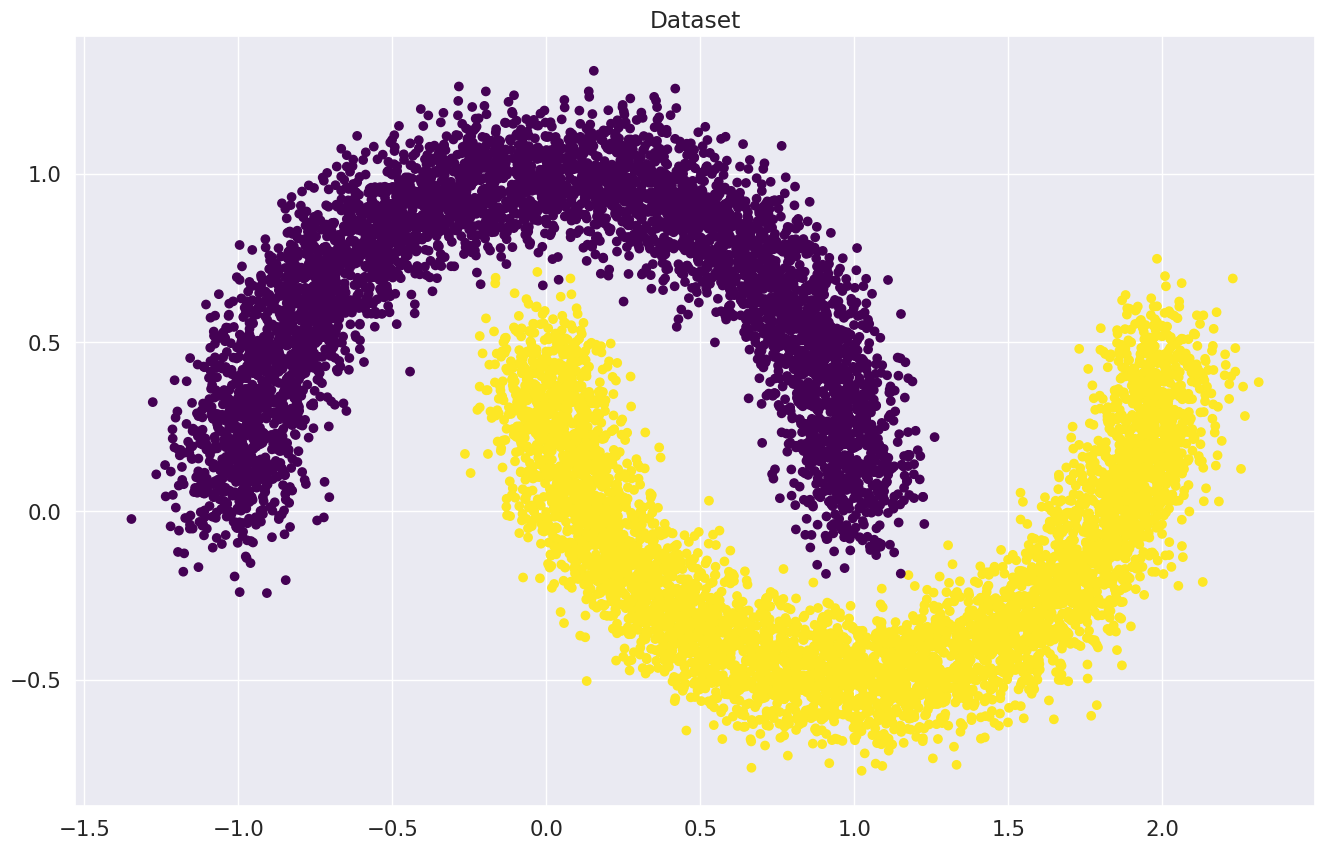

In [6]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [22]:
X_train_t = torch.from_numpy(np.float32(X_train))
y_train_t = torch.from_numpy(np.float32(y_train))
X_val_t =  torch.from_numpy(np.float32(X_val))
y_val_t =  torch.from_numpy(np.float32(y_val))

train_dataset = TensorDataset(X_train_t, y_train_t)

Создаем `Dataset` и `DataLoader`. 

In [23]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоиды берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [24]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features)) #, out_features)))
        self.bias = bias
        if bias:
            # bias должен быть тензором размера = количеству выходных нейронам
            self.bias_term = nn.Parameter(torch.rand(out_features)) 
    def forward(self, x):
        x =  x@self.weights.T
        if self.bias:
            x += self.bias_term
        return x

In [25]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [26]:
!pip3 install torch-summary
from torchsummary import summary
summary(linear_regression)

Layer (type:depth-idx)                   Param #
└─LinearRegression: 0-1                  3
Total params: 3
Trainable params: 3
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
└─LinearRegression: 0-1                  3
Total params: 3
Trainable params: 3
Non-trainable params: 0

In [27]:
#YOUR CODE второй вариант посмотреть количество параметров
sum(i.numel() for i in linear_regression.parameters())

3

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

**Ответ.** Получилось 3 обучаемых параметра.

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [28]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) 
        loss = loss_function(outp, y_batch)
        
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =   torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.8046875
Iteration: 100
Batch accuracy: 0.8828125
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9296875

Iteration: 342.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 755

### Визуализируем результаты

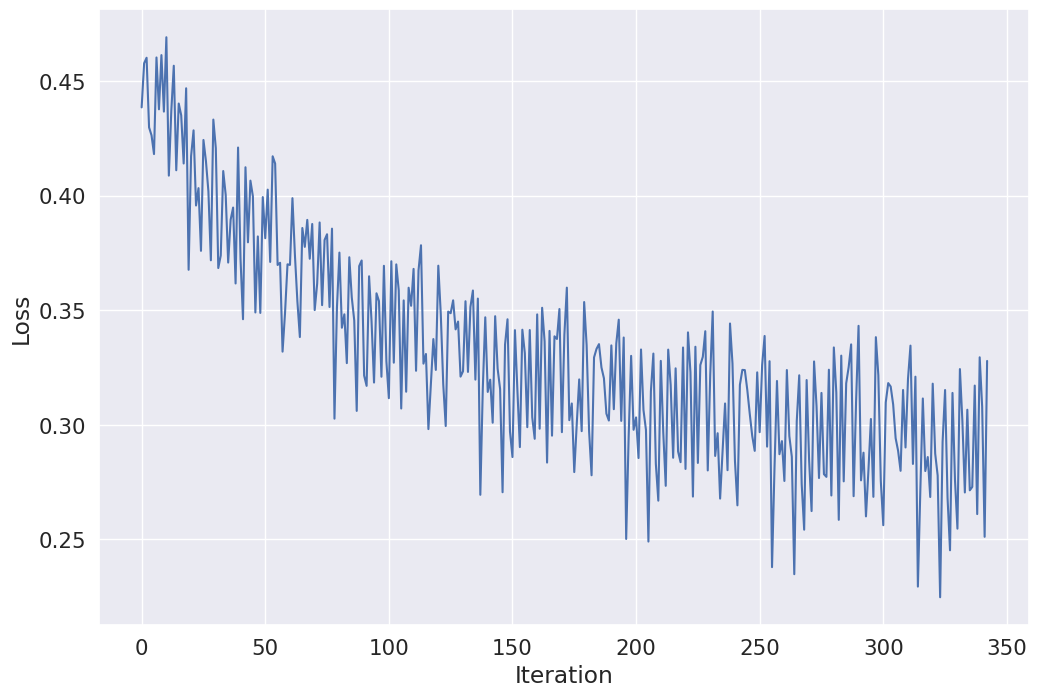

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

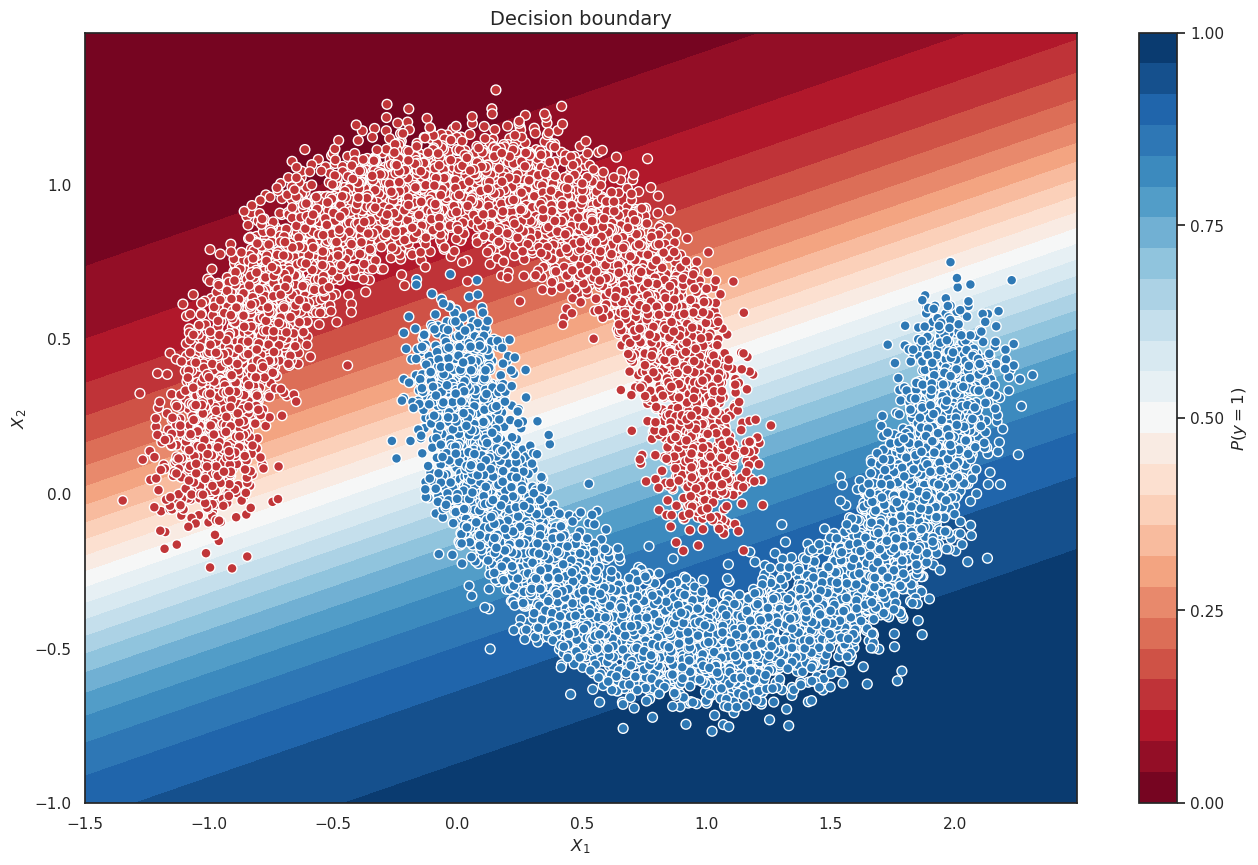

In [30]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [31]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probabilities = torch.sigmoid(model(x_batch))
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [32]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
#accuracy_score(y_train, (predict(train_dataloader, linear_regression)>0.5).astype(np.float32) )
accuracy_score(y_val, predict(val_dataloader, linear_regression))

0.8868

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8636

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [33]:
import os
import torchvision.transforms as tfs 
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=128) # YOUR CODE GOES HERE

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [45]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [34]:
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
D_in = 28*28 # размер изображения
H, D_out = 128, 10

In [35]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(D_in, H), # первый скрытый слой
    activation(),       # его активация
    nn.Linear(H, H),    # второй скрытый слой
    activation(),       # его активация
    nn.Linear(H, D_out), # выходной слой
 )

In [36]:
#criterion = #YOUR CODE. Select a loss function
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [38]:
device

'cpu'

In [39]:
#Печаль - я израсходовал лимит ГПУ.Считать будем на ЦПУ.

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [40]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()  # обнуляем градиенты модели
                #outp = model(x_batch)
                outp = model(x_batch.to(device))
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():  
                    outp = model(x_batch) 
                    
            preds = outp.argmax(-1)
            #correct =  # YOUR CODE GOES HERE
            #all =  # YOUR CODE GOES HERE
            correct = (preds == y_batch).sum() 
            all = y_batch.shape[0] 
            
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch) 
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()  
                optimizer.step() 
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8796833333333334
Loader: valid. Accuracy: 0.9207
Epoch: 2
Loader: train. Accuracy: 0.9412333333333334
Loader: valid. Accuracy: 0.9505
Epoch: 3
Loader: train. Accuracy: 0.9588333333333333
Loader: valid. Accuracy: 0.953
Epoch: 4
Loader: train. Accuracy: 0.9688166666666667
Loader: valid. Accuracy: 0.9629
Epoch: 5
Loader: train. Accuracy: 0.9751166666666666
Loader: valid. Accuracy: 0.9674
Epoch: 6
Loader: train. Accuracy: 0.97905
Loader: valid. Accuracy: 0.9703
Epoch: 7
Loader: train. Accuracy: 0.9820166666666666
Loader: valid. Accuracy: 0.9694
Epoch: 8
Loader: train. Accuracy: 0.9845833333333334
Loader: valid. Accuracy: 0.9711
Epoch: 9
Loader: train. Accuracy: 0.9859833333333333
Loader: valid. Accuracy: 0.9698
Epoch: 10
Loader: train. Accuracy: 0.9851333333333333
Loader: valid. Accuracy: 0.9678


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [41]:
elu_accuracy = accuracy["valid"]

In [42]:
def create_model(activation):
  return nn.Sequential(
             nn.Flatten(),
             nn.Linear(D_in, H),
             activation(),
             nn.Linear(H, H),
             activation(),
             nn.Linear(H, D_out),
  )

In [43]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

criterion = torch.nn.CrossEntropyLoss()
loaders = {"train": train_dataloader, "valid": valid_dataloader}

def test_activation_function(activation):
    model = create_model(activation)
    optimizer = torch.optim.Adam(model.parameters())

    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                #outp = model(x_batch)
                outp = model(x_batch.to(device))
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                    
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        else:
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all) 
    return accuracy['valid']

In [46]:
print(' Plain ')
plain_accuracy = test_activation_function(Identical)
print('ReLU')
relu_accuracy = test_activation_function(nn.ReLU)
print('LeakyReLU')
leaky_relu_accuracy =  test_activation_function(nn.LeakyReLU)

 Plain 
Epoch: 1
Loader: valid. Accuracy: 0.8834
Epoch: 2
Loader: valid. Accuracy: 0.8998
Epoch: 3
Loader: valid. Accuracy: 0.8989
Epoch: 4
Loader: valid. Accuracy: 0.8993
Epoch: 5
Loader: valid. Accuracy: 0.8997
Epoch: 6
Loader: valid. Accuracy: 0.9008
Epoch: 7
Loader: valid. Accuracy: 0.9006
Epoch: 8
Loader: valid. Accuracy: 0.9018
Epoch: 9
Loader: valid. Accuracy: 0.9025
Epoch: 10
Loader: valid. Accuracy: 0.9032
ReLU
Epoch: 1
Loader: valid. Accuracy: 0.9229
Epoch: 2
Loader: valid. Accuracy: 0.9469
Epoch: 3
Loader: valid. Accuracy: 0.9555
Epoch: 4
Loader: valid. Accuracy: 0.9589
Epoch: 5
Loader: valid. Accuracy: 0.9646
Epoch: 6
Loader: valid. Accuracy: 0.9662
Epoch: 7
Loader: valid. Accuracy: 0.968
Epoch: 8
Loader: valid. Accuracy: 0.9698
Epoch: 9
Loader: valid. Accuracy: 0.9663
Epoch: 10
Loader: valid. Accuracy: 0.9675
LeakyReLU
Epoch: 1
Loader: valid. Accuracy: 0.9157
Epoch: 2
Loader: valid. Accuracy: 0.9461
Epoch: 3
Loader: valid. Accuracy: 0.9524
Epoch: 4
Loader: valid. Accuracy:

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

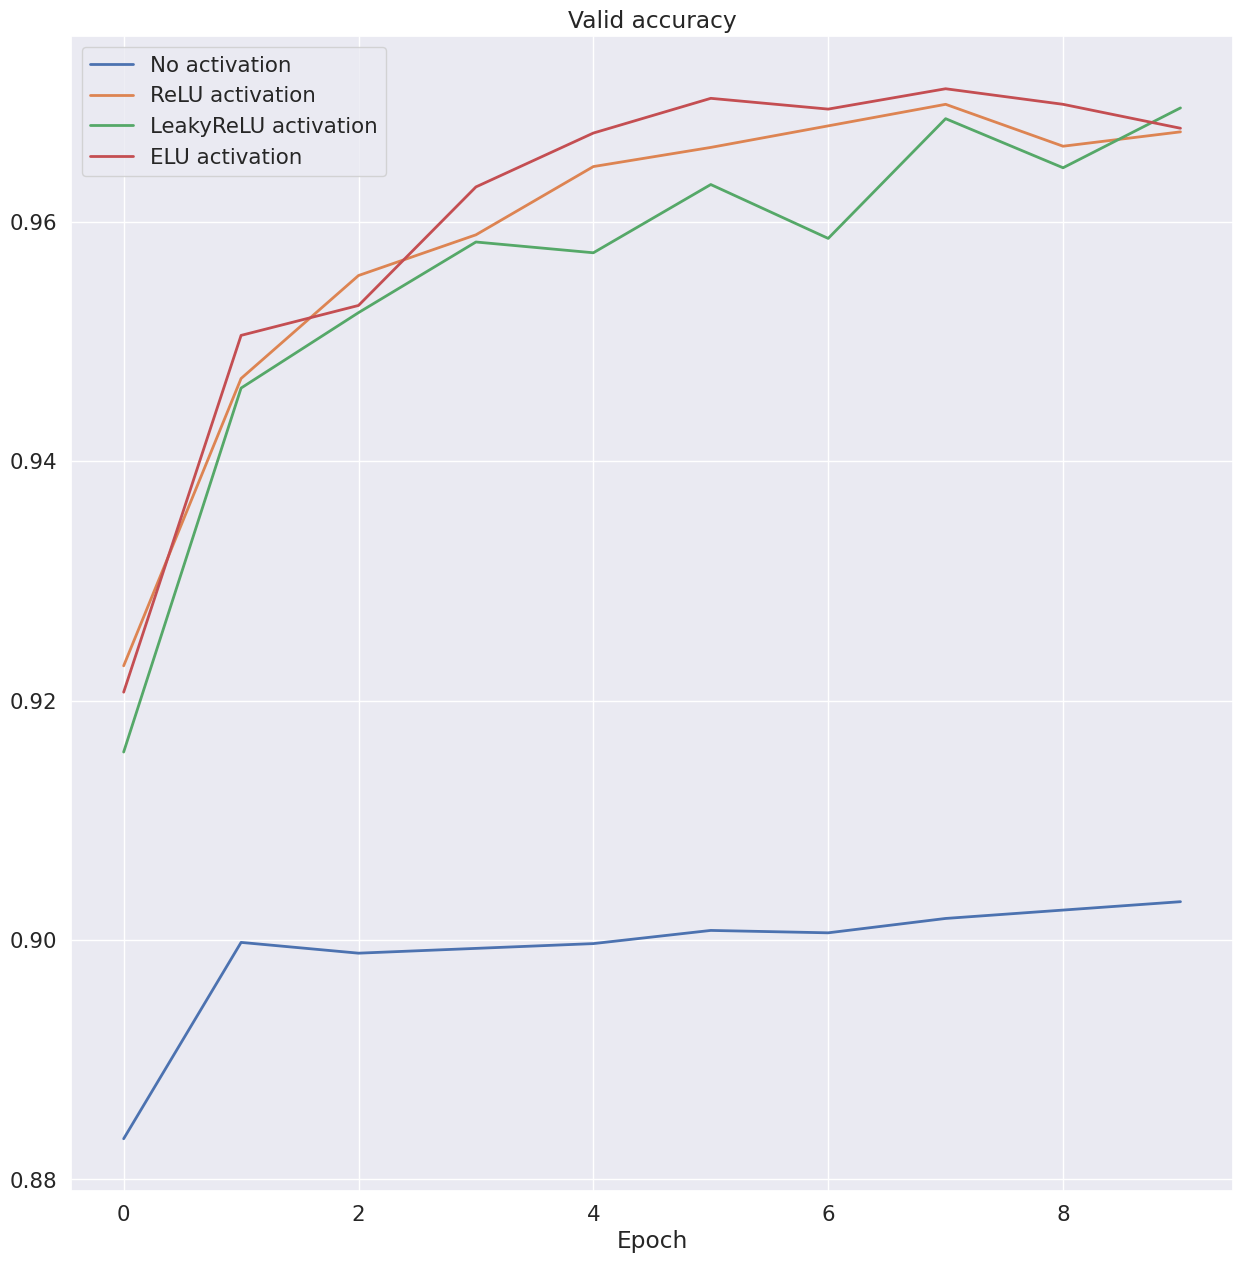

In [47]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(15, 15))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

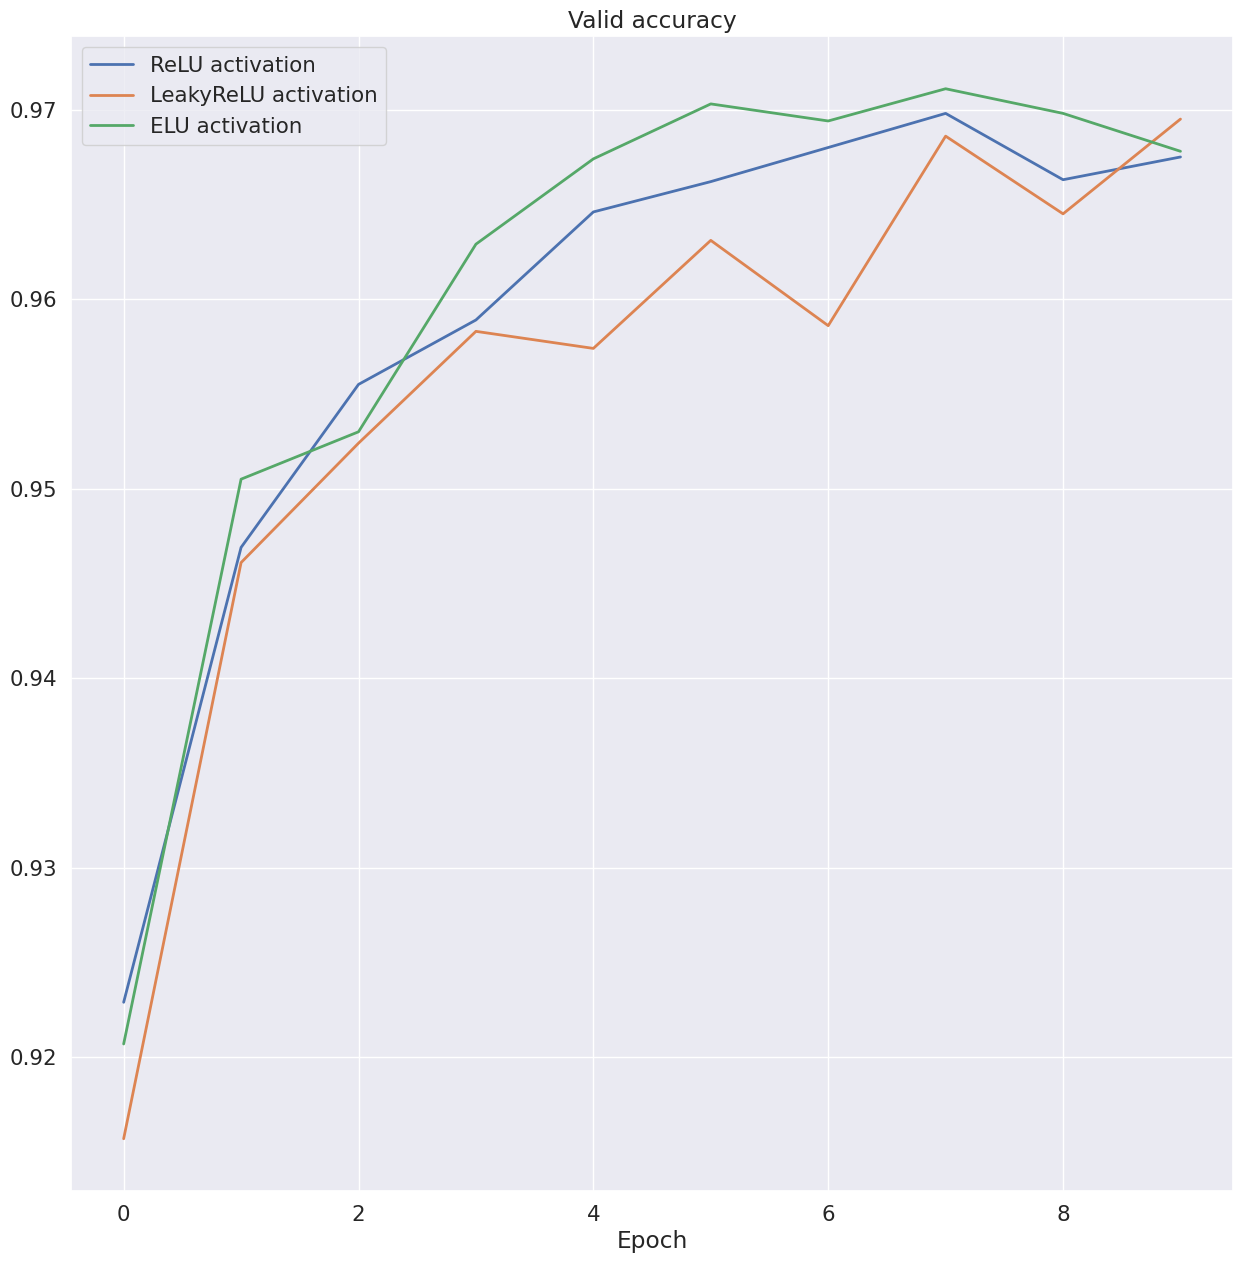

In [48]:
plt.figure(figsize=(15, 15))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyReLU activation

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [49]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-11-12 01:16:22--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village.kz (img.the-village.kz)… 144.76.208.75
Подключение к img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [переход]
--2022-11-12 01:16:23--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village-kz.com (img.the-village-kz.com)… 144.76.208.75
Подключение к img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 49337 (48K) [image/jpeg]
Сохранение в: «sample_photo.jpg»

sample_photo.jpg    100%[===================>]  48,18K  --.-KB/s    за 0,09s   

2022-11-12 01:16:23 (542 KB/s) - «sample_

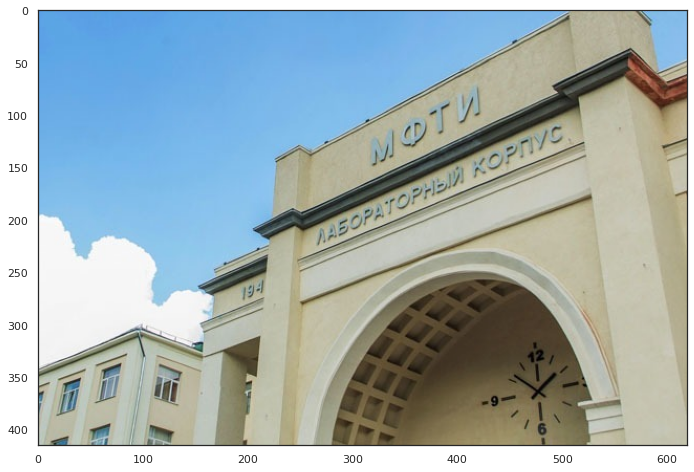

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
#    [0, 0, 0],
#    [1, -2, 1],
#    [0, 0, 0]
#    [0, 1, 0],
#    [1, -4, 1],
#    [0, 1, 0]
#    [0, -1, 0],
#    [-1, 5, -1],
#    [0, -1, 0]
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

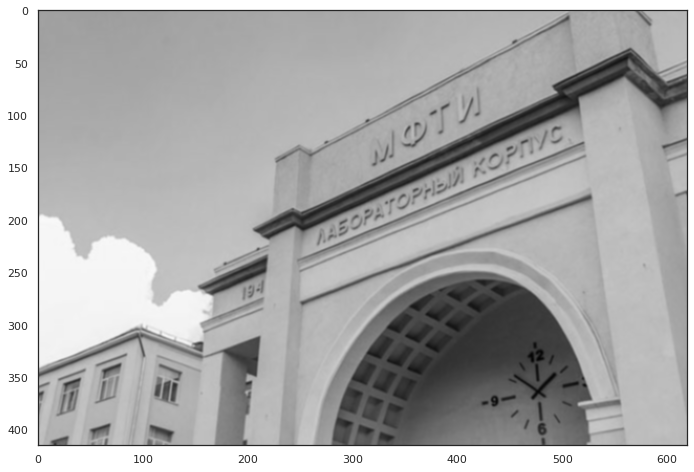

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А3, Б5, В4, Г6, Д2, Е1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [50]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.conv2 = nn.Conv2d(6, 16, 3) 
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        #x = #YOUR CODE. Apply layers created in __init__. 
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)    
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
#<YOUR CODE>
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                    
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward() 
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8793166666666666
Loader: valid. Accuracy: 0.9638
Epoch: 2
Loader: train. Accuracy: 0.9707166666666667
Loader: valid. Accuracy: 0.9747
Epoch: 3
Loader: train. Accuracy: 0.9797
Loader: valid. Accuracy: 0.981
Epoch: 4
Loader: train. Accuracy: 0.9845333333333334
Loader: valid. Accuracy: 0.9837
Epoch: 5
Loader: train. Accuracy: 0.9872
Loader: valid. Accuracy: 0.9849
Epoch: 6
Loader: train. Accuracy: 0.9890666666666666
Loader: valid. Accuracy: 0.9848
Epoch: 7
Loader: train. Accuracy: 0.9908166666666667
Loader: valid. Accuracy: 0.9843
Epoch: 8
Loader: train. Accuracy: 0.9920333333333333
Loader: valid. Accuracy: 0.9842
Epoch: 9
Loader: train. Accuracy: 0.9933333333333333
Loader: valid. Accuracy: 0.9852
Epoch: 10
Loader: train. Accuracy: 0.9945166666666667
Loader: valid. Accuracy: 0.9847


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

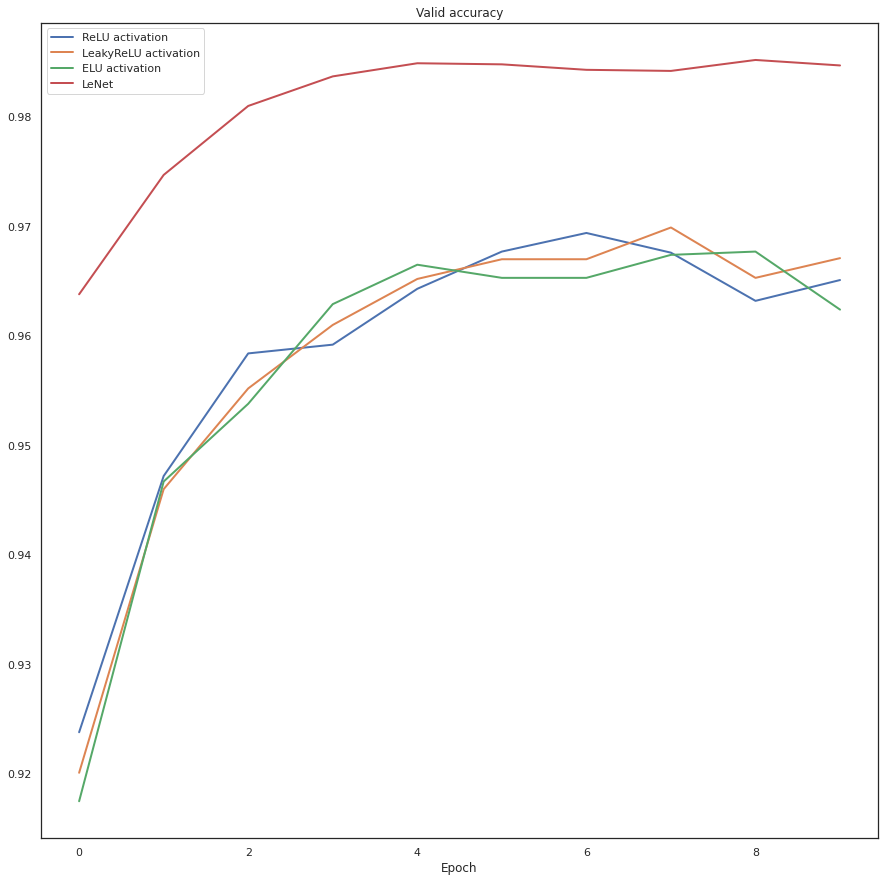

In [ ]:
plt.figure(figsize=(15, 15))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99.